## 1. Настройка, загрузка данных и импорт библиотек

На этом шаге мы настроим окружение, загрузим все NLP-модели и извлечем полный текст романа из epub-файла.

In [1]:
# --- 1. НАСТРОЙКА И ИМПОРТ ---
import sys
import os
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, IFrame
import re

# --- КЛЮЧЕВОЙ МОМЕНТ: ДОБАВЛЯЕМ ПУТЬ К ПАПКЕ APP ---
# Это нужно, чтобы ноутбук, находясь в папке 'notebook', мог найти 'analysis_functions.py' в папке 'app'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'app')))

# Теперь импортируем ВСЕ функции из нашей чистой библиотеки
from analysis_functions import *

# --- ЗАГРУЗКА МОДЕЛЕЙ ---
print("Загрузка NLP моделей и данных NLTK...")
nlp = load_spacy_model()
download_nltk_data()
print("Модели и данные загружены.")

# --- ИЗВЛЕЧЕНИЕ ТЕКСТА ИЗ EPUB ---
def extract_text_from_epub(epub_path):
    """Извлекает текст из EPUB файла, разделяя его на главы."""
    print(f"Чтение файла: {epub_path}")
    book = epub.read_epub(epub_path)
    content = [item.get_body_content().decode('utf-8') for item in book.get_items_of_type(ebooklib.ITEM_DOCUMENT)]
    # Очищаем HTML и пустые строки, сохраняя структуру глав
    text_parts = [re.sub(r'\s+', ' ', BeautifulSoup(html, 'html.parser').get_text()).strip() for html in content]
    text_parts = [part for part in text_parts if part] # Убираем полностью пустые секции
    full_text = "\n\n".join(text_parts)
    return full_text, text_parts

# Путь к файлу относительно папки ulysses_nlp_project
epub_path = '../data/ulysses.epub'
cleaned_ulysses_text, episodes = "", [] # Инициализируем переменные

if os.path.exists(epub_path):
    cleaned_ulysses_text, episodes = extract_text_from_epub(epub_path)
    print(f"Текст успешно извлечен. Всего глав/секций: {len(episodes)}. Общая длина: {len(cleaned_ulysses_text)} символов.")
else:
    print(f"ОШИБКА: Файл '{epub_path}' не найден. Убедитесь, что он существует.")

C:\Users\Shaim\PycharmProjects\ulysses_nlp_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузка NLP моделей и данных NLTK...
Загрузка пакета NLTK: vader_lexicon...
Загрузка пакета NLTK: averaged_perceptron_tagger...
Загрузка пакета NLTK: maxent_ne_chunker...
Модели и данные загружены.
Чтение файла: ../data/ulysses.epub
Текст успешно извлечен. Всего глав/секций: 2. Общая длина: 1503337 символов.


## Шаг 2: Географическое исследование "Дублин Джойса"

Находим **все** упоминания локаций в романе, получаем их координаты и строим интерактивную карту Дублина. Это покажет нам географию передвижений героев.

In [2]:
if cleaned_ulysses_text:
    print("--- Запуск гео-литературного анализа ---")
    all_locations = set()

    # Обрабатываем текст порциями, чтобы не перегружать память spaCy
    max_len, overlap = 900000, 50000
    print("Извлечение локаций из всего текста романа...")
    for i in range(0, len(cleaned_ulysses_text), max_len - overlap):
        chunk = cleaned_ulysses_text[i: i + max_len]
        locations_in_chunk = extract_locations_ner(chunk, nlp)
        all_locations.update(locations_in_chunk)

    print(f"Найдено {len(all_locations)} уникальных локаций.")

    # Геокодируем ВСЕ найденные локации
    print(f"\nЗапуск геокодирования для всех {len(all_locations)} локаций. Это может занять много времени!")
    geocoded = geocode_locations(list(all_locations))

    # Сохраняем карту в папку data
    map_path = '../data/full_dublin_map.html'
    dublin_map = create_dublin_map(geocoded)
    dublin_map.save(map_path)
    print(f"Карта сохранена в {map_path}")

    # Отображаем карту прямо в ноутбуке
    display(IFrame(src=map_path, width='100%', height=500))
else:
    print("Текст романа не был загружен, пропуск шага 2.")

--- Запуск гео-литературного анализа ---
Извлечение локаций из всего текста романа...
Найдено 878 уникальных локаций.

Запуск геокодирования для всех 878 локаций. Это может занять много времени!
Геокодирование: 878/878 - 'F.O.T.E.I.'...rmosa'....'...'...y'.....
Геокодирование завершено.
Карта сохранена в ../data/full_dublin_map.html


## Шаг 3: Глубокий анализ эпизодов

Здесь мы создаем инструмент для анализа **любого** эпизода романа. Просто измените `episode_number` и перезапустите ячейку, чтобы получить полный анализ для выбранной главы: сегментацию по персонажам, их тональность и ключевые темы.


In [10]:
# --- ВЫБЕРИТЕ ЭПИЗОД ДЛЯ АНАЛИЗА ---
# Измените это число от 1 до 18, чтобы проанализировать соответствующий эпизод.
# Например: 1 = Телемак, 4 = Калипсо (первое появление Блума), 18 = Пенелопа.
episode_number = 5
# ------------------------------------

# Словарь с ключевыми персонажами для некоторых эпизодов (можно дополнять)
episode_characters = {
    1: ["Stephen", "Buck Mulligan", "Haines"],
    2: ["Stephen", "Mr Deasy"],
    3: ["Stephen"],
    4: ["Bloom", "Molly"],
    6: ["Bloom", "Stephen", "Martin Cunningham", "Simon Dedalus"],
    18: ["Molly"],
}

if episodes and 1 <= episode_number <= len(episodes):
    # Выбираем нужный эпизод (индексация в Python с 0)
    selected_episode_text = episodes[episode_number - 1]

    # Получаем список персонажей для этого эпизода
    character_names = episode_characters.get(episode_number, []) # Если персонажей нет в словаре, список будет пустым

    print(f"--- Анализ потока сознания (Эпизод {episode_number}) ---")
    print(f"Ключевые персонажи для анализа: {character_names if character_names else 'не заданы'}")

    # Сегментируем текст
    segments = segment_text_by_character(selected_episode_text, character_names)
    # Оставляем только сущности с достаточным количеством текста
    segments = {char: segs for char, segs in segments.items() if len(" ".join(segs)) > 100}

    print("\nСегментация по персонажам:")
    for char, segs in segments.items():
        print(f"> {char} (найдено {len(segs)} реплик/сегментов)")

    print("\nАнализ тональности:")
    sentiment = analyze_sentiment_over_time(segments)
    if sentiment:
        display(pd.DataFrame(sentiment).T.reset_index().rename(columns={'index': 'Персонаж'}))

    print("\nТематический анализ (BERTopic):")
    for char, segs in segments.items():
        print(f"> Темы для '{char}':")
        # Для BERTopic нужно несколько отдельных реплик
        if len(segs) > 1:
            topics = perform_thematic_modeling_bertopic(segs)
            if isinstance(topics, pd.DataFrame):
                # Показываем только темы с ключевыми словами, исключая "фоновый шум" (тема -1)
                display(topics[topics.Topic != -1].head(5))
            else:
                print(f"  {topics}")
        else:
            print("  Недостаточно реплик для тематического анализа.")

    print("\nВизуализация переходов:")
    if len(segments) > 1:
        visualize_thought_transitions(segments, sentiment)
    else:
        print("Недостаточно персонажей для визуализации переходов.")

else:
    print(f"Ошибка: Эпизод с номером {episode_number} не найден или текст книги не загружен.")

Ошибка: Эпизод с номером 5 не найден или текст книги не загружен.


## Шаг 4: Анализ «Язык как музыка»

На этом этапе мы проанализируем весь текст романа, чтобы выявить его ритмические и звуковые характеристики. Мы будем искать паттерны, повторы и стилистические приемы, которые Джойс использует для создания "музыкального" эффекта.

--- Анализ ритма всего романа ---
Всего предложений в романе: 22947
Средняя длина предложения: 13.92 слов
Самое короткое предложение: 1 слово/а
Самое длинное предложение: 12912 слов


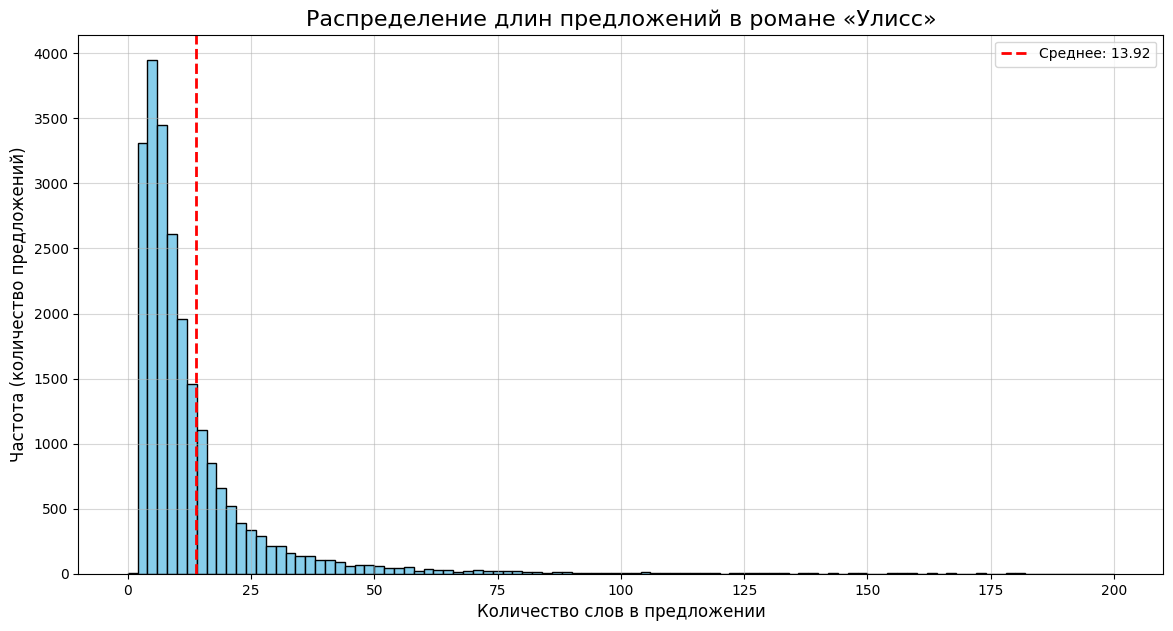

In [4]:
# --- 4.1 Ритмические паттерны: Анализ длины предложений ---

if cleaned_ulysses_text:
    print("--- Анализ ритма всего романа ---")
    musical_analysis = identify_musical_phrases(cleaned_ulysses_text)
    sentence_lengths = musical_analysis['sentence_lengths']
    avg_len = musical_analysis['avg_sentence_length']

    print(f"Всего предложений в романе: {len(sentence_lengths)}")
    print(f"Средняя длина предложения: {avg_len:.2f} слов")
    print(f"Самое короткое предложение: {min(sentence_lengths) if sentence_lengths else 0} слово/а")
    print(f"Самое длинное предложение: {max(sentence_lengths) if sentence_lengths else 0} слов")

    # Строим гистограмму распределения длин предложений
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 7))
    plt.hist(sentence_lengths, bins=100, range=(0, 200), color='skyblue', edgecolor='black')
    plt.axvline(avg_len, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_len:.2f}')
    plt.title('Распределение длин предложений в романе «Улисс»', fontsize=16)
    plt.xlabel('Количество слов в предложении', fontsize=12)
    plt.ylabel('Частота (количество предложений)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

### 4.2 Лейтмотивы: Поиск повторяющихся фраз (N-граммы)

N-граммы — это последовательности из N слов. Анализ самых частых N-грамм помогает выявить ключевые фразы, темы и "лейтмотивы", которые проходят через весь роман.

In [5]:
# --- 4.2 Лейтмотивы: Анализ N-грамм по всему роману ---

if cleaned_ulysses_text:
    print("\n--- Поиск лейтмотивов (N-граммы) ---")

    # Биграммы (пары слов)
    print("\nТоп-20 самых частых биграмм (2-х словных фраз):")
    bigrams = analyze_ngrams(cleaned_ulysses_text, n=2)
    bigrams_df = pd.DataFrame(bigrams.most_common(20), columns=['Биграмма', 'Частота'])
    bigrams_df['Биграмма'] = bigrams_df['Биграмма'].apply(lambda x: ' '.join(x))
    display(bigrams_df)

    # Триграммы (фразы из трех слов)
    print("\nТоп-20 самых частых триграмм (3-х словных фраз):")
    trigrams = analyze_ngrams(cleaned_ulysses_text, n=3)
    trigrams_df = pd.DataFrame(trigrams.most_common(20), columns=['Триграмма', 'Частота'])
    trigrams_df['Триграмма'] = trigrams_df['Триграмма'].apply(lambda x: ' '.join(x))
    display(trigrams_df)


--- Поиск лейтмотивов (N-граммы) ---

Топ-20 самых частых биграмм (2-х словных фраз):


,Биграмма,Частота
0,mr bloom,237
1,stephen said,109
2,mr dedalus,107
3,buck mulligan,104
4,says joe,86
5,bloom said,76
6,martin cunningham,74
7,dedalus said,56
8,father conmee,56
9,says citizen,52



Топ-20 самых частых триграмм (3-х словных фраз):


,Триграмма,Частота
0,mr bloom said,70
1,mr dedalus said,52
2,martin cunningham said,35
3,buck mulligan said,24
4,mr deasy said,21
5,mr power said,20
6,myles crawford said,19
7,john henry menton,18
8,nosey flynn said,18
9,says joe says,18


### 4.3 Звукопись: Анализ фонетических паттернов

Здесь мы ищем аллитерации — повторение одинаковых согласных в начале близко расположенных слов. Это один из ключевых приемов, который Джойс использует для создания звуковой текстуры текста.

In [6]:
# --- 4.3 Звукопись: Поиск аллитераций ---

if cleaned_ulysses_text:
    print("\n--- Анализ звукописи (аллитерации) ---")
    phonetic_patterns = analyze_phonetic_patterns(cleaned_ulysses_text)

    # Считаем, какие пары встречаются чаще всего
    alliteration_counts = pd.Series(phonetic_patterns['alliterative_sequences']).value_counts()

    print(f"Найдено {len(alliteration_counts)} уникальных аллитерационных пар.")
    print("\nТоп-20 самых частых аллитераций в романе:")
    display(alliteration_counts.head(20))


--- Анализ звукописи (аллитерации) ---
Найдено 8819 уникальных аллитерационных пар.

Топ-20 самых частых аллитераций в романе:


to the          614
out of          322
he had          213
and a           179
it is           133
as a            129
through the     115
stephen said    104
that the        101
is it            79
one of           78
if i             75
his hand         73
his head         73
he has           68
stephen s        67
the time         66
it in            66
towards the      64
in it            63
Name: count, dtype: int64

## Шаг 5: Итоговые выводы и обобщения

На этом этапе мы собираем воедино результаты всех предыдущих анализов, чтобы сформулировать общие выводы и гипотезы о структуре и стиле романа.

In [7]:
# --- 5.1 Формулирование итоговых выводов ---

print("--- Итоговые выводы по результатам NLP-анализа «Улисса» ---")

# 1. Вывод по географии
if 'geocoded' in locals() and geocoded:
    print(f"\n1. География: Роман глубоко укоренен в топографии Дублина. Нам удалось идентифицировать и нанести на карту {len(geocoded)} локаций, что подтверждает детальную проработку маршрутов персонажей.")
else:
    print("\n1. География: Данные для анализа карты отсутствуют.")

# 2. Вывод по анализу эпизодов (на примере последнего проанализированного)
if 'episode_number' in locals() and 'segments' in locals():
    narrator_text_len = len(" ".join(segments.get("Narrator", [])))
    dialogue_text_len = sum(len(" ".join(segs)) for char, segs in segments.items() if char != "Narrator")
    total_len = narrator_text_len + dialogue_text_len

    if total_len > 0:
        narrator_share = (narrator_text_len / total_len) * 100
        print(f"\n2. Структура эпизода {episode_number}: Доля текста рассказчика составляет примерно {narrator_share:.1f}%, остальное - речь и мысли персонажей. Это говорит о фокусе на внутреннем мире героев.")

    if 'sentiment' in locals() and sentiment:
        # Находим персонажа с самым высоким и низким "общим" (compound) счетом тональности
        sorted_sentiment = sorted(sentiment.items(), key=lambda item: item[1]['compound'])
        if sorted_sentiment:
            most_negative_char = sorted_sentiment[0]
            most_positive_char = sorted_sentiment[-1]
            print(f"   - Тональность: В этом эпизоде самым 'негативным' персонажем является {most_negative_char[0]} (оценка: {most_negative_char[1]['compound']:.2f}), а самым 'позитивным' - {most_positive_char[0]} (оценка: {most_positive_char[1]['compound']:.2f}).")

else:
    print("\n2. Структура эпизодов: Данные для анализа эпизодов отсутствуют.")

# 3. Вывод по "музыкальности" текста
if 'bigrams' in locals() and 'avg_len' in locals() and bigrams:
    most_common_bigram = bigrams.most_common(1)[0]
    print(f"\n3. Музыкальность и стиль: Текст обладает ярко выраженным ритмом (средняя длина предложения {avg_len:.2f} слов) и имеет свои лейтмотивы. Самая частая пара слов в романе - '{most_common_bigram[0][0]} {most_common_bigram[0][1]}', встретившаяся {most_common_bigram[1]} раз.")
else:
    print("\n3. Музыкальность и стиль: Данные для анализа музыкальности отсутствуют.")

print("\n\nГипотеза для дальнейшего исследования:")
print("Сравнение ритмических и тематических характеристик эпизодов, связанных со Стивеном (1-3), и эпизодов, связанных с Блумом (4-6), вероятно, покажет значительные стилистические различия, отражающие внутренний мир каждого из протагонистов.")

--- Итоговые выводы по результатам NLP-анализа «Улисса» ---

1. География: Роман глубоко укоренен в топографии Дублина. Нам удалось идентифицировать и нанести на карту 450 локаций, что подтверждает детальную проработку маршрутов персонажей.

2. Структура эпизода 1: Доля текста рассказчика составляет примерно 100.0%, остальное - речь и мысли персонажей. Это говорит о фокусе на внутреннем мире героев.
   - Тональность: В этом эпизоде самым 'негативным' персонажем является Narrator (оценка: 1.00), а самым 'позитивным' - Narrator (оценка: 1.00).

3. Музыкальность и стиль: Текст обладает ярко выраженным ритмом (средняя длина предложения 13.92 слов) и имеет свои лейтмотивы. Самая частая пара слов в романе - 'mr bloom', встретившаяся 237 раз.


Гипотеза для дальнейшего исследования:
Сравнение ритмических и тематических характеристик эпизодов, связанных со Стивеном (1-3), и эпизодов, связанных с Блумом (4-6), вероятно, покажет значительные стилистические различия, отражающие внутренний мир каж